Notebook to train several Neural Network models on the manually transformed raw data obtained from project_TS_process.ipynb

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm  # Import tqdm
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
import numpy as np
import glob
import os

In [5]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce RTX 4070 SUPER


In [6]:
def load_all_partitions(directory):
    all_files = glob.glob(os.path.join(directory, '*.csv'))
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Usage
x = load_all_partitions('data/AF-Raw-Data/AF Data/all_raw_data_csv')
# x = pd.read_csv('data/AF-Raw-Data/AF Data/data_samples_40_all.csv') #OLD

Load the data and discard some samples

In [7]:
#print the number of lines:
print(len(x))

# Remove duplicates, because we don't want overtrain on certain samples
n_1 = len(x)
x = x.drop_duplicates()
n_2 = len(x)
print(f'Removed {n_1 - n_2} duplicates')

# Remove unphysical values
n_1 = len(x)
x = x[(x.T < 1800).all()]
n_2 = len(x)
print(f'Removed {n_1 - n_2} rows with values above 1800')

1728431
Removed 10874 duplicates
Removed 125196 rows with values above 1800


Class distribution before and after balancing

In [8]:
x['Class_Label'].value_counts() #deletes a LOT of duplicates

Class_Label
0.0    1537725
1.0      54636
Name: count, dtype: int64

In [5]:
# balance the dataset by taking the same number of samples from each class
class_1 = x[x['Class_Label'] == 1]
class_0 = x[x['Class_Label'] == 0].sample(len(class_1))
x = pd.concat([class_1, class_0])
x['Class_Label'].value_counts()

1.0    54636
0.0    54636
Name: Class_Label, dtype: int64

Inspect the distribution of R-R intervals of the whole dataset

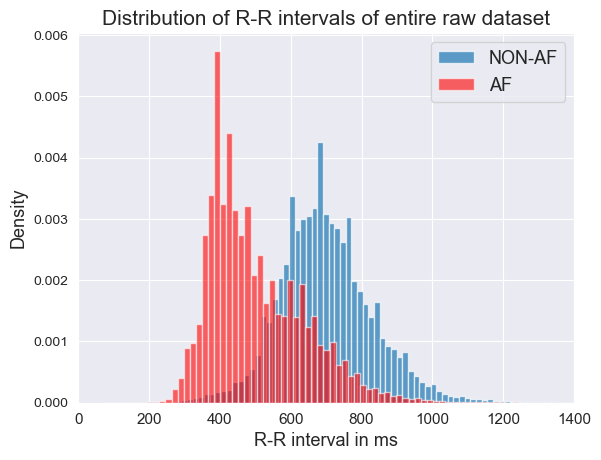

In [6]:
f_class_0 = class_0.iloc[:, :-1].values.flatten()
f_class_1 = class_1.iloc[:, :-1].values.flatten()

plt.hist(f_class_0, bins=100, alpha=0.7, label='NON-AF', density=True)
plt.hist(f_class_1, bins=100, alpha=0.6, label='AF', color='r', density=True)

plt.xlabel('R-R interval in ms', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Distribution of R-R intervals of entire raw dataset', fontsize=15)
plt.xlim(0, 1400)
plt.xticks(fontsize=11)
plt.legend(fontsize=13)
plt.savefig('images/R-R_intervals_distribution.png')
plt.show()

Creating our own version of the given pre-processed data
This won't be used for NN training, but for a Decision Tree classifier to verify the results of the given preprocessed data

In [7]:
# 30 bins (of 50 milliseconds) are created covering R-R intervals of 200 ms up to 1700 ms. For each
#sample the frequency of an R-R interval occurring in a certain bin was counted.

# Define the edges of the bins
bin_edges = np.arange(200, 1751, 50) #ms

# Function to bin and count intervals for a row
def bin_row(row, bin_edges):
    intervals = row[:-1].values # Exclude the class label from binning
    bin_indices = np.digitize(intervals, bins=bin_edges, right=False)
    bin_counts = np.bincount(bin_indices, minlength=len(bin_edges)+1)[1:-1]  # Exclude counts outside defined bins
    return bin_counts

x_bins = x.apply(lambda row: bin_row(row, bin_edges), axis=1, result_type='expand')
x_bins.columns = [f'bin_{i + 1}' for i in range(len(bin_edges) - 1)]
x_bins['Class_Label'] = x['Class_Label']

# print(binned_counts.head())

Define various Neural Network models

In [8]:
output_dim = 1  # binary classification

class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()

        # Parameters
        self.hidden_dim = 128 # number of LSTM cells
        self.num_layers = 2 # number of LSTM layers
        self.input_dim = 1 
        
        # Layers
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # One time step (the last one) of outputs
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Only need to get the output of the last timestep
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

class FC_model(nn.Module):
    def __init__(self):
        super(FC_model, self).__init__()

        self.input_dim = 40 
        self.h1 = 128 
        self.h2 = 64  
        self.output_dim = 1  # Output size, 1 for binary classification

        # layers
        self.fc1 = nn.Linear(self.input_dim, self.h1) 
        self.fc2 = nn.Linear(self.h1, self.h2) 
        self.fc3 = nn.Linear(self.h2, self.output_dim)  

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Reshape x to [batch_size, input_dim*1]
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x))
        return x

class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.num_features = 1
        self.output_dim = 1

        self.conv1 = nn.Conv1d(in_channels=self.num_features, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # divide by 2 twice because of the pooling layers
        sequence_length_after_convs = 10

        # Calculate the correct input size for the first FC layer
        self.fc_input_size = 32 * sequence_length_after_convs  # 32 channels from the last conv layer times the reduced length of the sequence

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 64)  # First FC layer
        self.fc2 = nn.Linear(64, self.output_dim)     # Second FC layer, outputting the prediction for binary classification

    def forward(self, x):
        # Ensure x is in the correct shape [batch, channels, seq_len]
        x = x.view(x.size(0), self.num_features, -1)

        # Apply convolutions followed by pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # First FC layer with ReLU activation
        x = self.fc2(x)          # Second FC layer, output layer with sigmoid for binary classification in next step

        return torch.sigmoid(x)  # Apply sigmoid activation for binary classification


In [9]:
# CNN LSTM MODEL
class CNN_LSTM_Model(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Model, self).__init__()

        self.dropout_prob = 0.4

        # CNN part
        self.num_features = 1  # Assuming 1-dimensional features for simplicity
        self.conv1 = nn.Conv1d(in_channels=self.num_features, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(self.dropout_prob)

        # LSTM part
        self.hidden_dim = 128  # Number of features in the hidden state
        self.num_layers = 2  # Number of recurrent layers
        self.seq_length_after_convs = 10
        self.lstm = nn.LSTM(32, self.hidden_dim, self.num_layers, batch_first=True)  # 32 is the number of channels from the last conv layer

        # Fully connected part
        self.fc1 = nn.Linear(self.hidden_dim, 64)  # First FC layer
        self.dropout2 = nn.Dropout(self.dropout_prob)
        self.fc2 = nn.Linear(64, 1)  # Second FC layer, outputting the prediction for binary classification

    def forward(self, x):
        # Ensure x is in the correct shape [batch, channels, seq_len]
        x = x.view(x.size(0), self.num_features, -1)

        # CNN part
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)

        # Reshape output for LSTM input
        x = x.view(x.size(0), self.seq_length_after_convs, -1)  # [batch_size, seq_len, features]

        # LSTM part
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Get only the output of the last time step
        _, (hn, _) = self.lstm(x, (h0, c0))

        # Fully connected part
        # Take the last hidden state for the fully connected layers
        x = hn[-1,:,:]  # Taking the hidden state of the last layer
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x


In [10]:
# Select a model:
#model = CNN_LSTM_Model()
#model = CNN_model()
#model = FC_model()
model = LSTM_model()

Prepare the data for training

In [11]:
# Hyperparameters
batch_size = 60
num_epochs = 15
initial_learning_rate = 0.001 # not needed to adjust, because Adam optimizer is used

In [12]:
# Split the data into training and testing sets
X = x.iloc[:, :-1].values
y = x.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


In [13]:
# Convert the normalized data and labels into PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Reshape the inputs to be [samples, time steps, features]
X_train_tensor = X_train_tensor.unsqueeze(2)  # Adds a dimension for the single feature
X_test_tensor = X_test_tensor.unsqueeze(2)

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Train the model

In [49]:
loss_function = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=initial_learning_rate)

train_accs = []
test_accs = []
train_losses = []
test_losses = []

model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    with tqdm(train_loader, unit="batch") as tepoch:  
        for inputs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")  # Set the description for the progress bar

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass           
            loss = loss_function(outputs.squeeze(), labels.float())  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()  # Using 0.5 as the threshold
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            tepoch.set_postfix(loss=loss.item())  # Display the loss in the progress bar

    # Calculate average loss and accuracy over an epoch
    train_losses.append(train_loss / total_train)
    train_accs.append(correct_train / total_train)

    # Get testing loss and accuracy for the epoch
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():  # No need to track the gradients during evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs.squeeze(), labels.float())
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()  # Using 0.5 as the threshold
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / total_test)
    test_accs.append(correct_test / total_test)

    # Print the epoch's summary
    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accs[-1]:.4f}')


Epoch 1: 100%|██████████| 1457/1457 [00:17<00:00, 82.58batch/s, loss=0.186] 


Epoch 1, Train Loss: 0.2719, Train Accuracy: 0.9056, Test Loss: 0.2012, Test Accuracy: 0.9392


Epoch 2: 100%|██████████| 1457/1457 [00:17<00:00, 84.97batch/s, loss=0.202] 


Epoch 2, Train Loss: 0.1760, Train Accuracy: 0.9493, Test Loss: 0.1598, Test Accuracy: 0.9544


Epoch 3: 100%|██████████| 1457/1457 [00:16<00:00, 86.41batch/s, loss=0.116] 


Epoch 3, Train Loss: 0.1555, Train Accuracy: 0.9571, Test Loss: 0.1513, Test Accuracy: 0.9574


Epoch 4: 100%|██████████| 1457/1457 [00:16<00:00, 86.88batch/s, loss=0.137] 


Epoch 4, Train Loss: 0.1480, Train Accuracy: 0.9588, Test Loss: 0.1445, Test Accuracy: 0.9585


Epoch 5: 100%|██████████| 1457/1457 [00:17<00:00, 82.71batch/s, loss=0.142] 


Epoch 5, Train Loss: 0.1440, Train Accuracy: 0.9594, Test Loss: 0.1457, Test Accuracy: 0.9587


Epoch 6: 100%|██████████| 1457/1457 [00:17<00:00, 81.88batch/s, loss=0.174] 


Epoch 6, Train Loss: 0.1404, Train Accuracy: 0.9602, Test Loss: 0.1450, Test Accuracy: 0.9581


Epoch 7: 100%|██████████| 1457/1457 [00:17<00:00, 82.29batch/s, loss=0.153] 


Epoch 7, Train Loss: 0.1387, Train Accuracy: 0.9604, Test Loss: 0.1406, Test Accuracy: 0.9587


Epoch 8: 100%|██████████| 1457/1457 [00:17<00:00, 82.16batch/s, loss=0.126] 


Epoch 8, Train Loss: 0.1367, Train Accuracy: 0.9609, Test Loss: 0.1379, Test Accuracy: 0.9598


Epoch 9: 100%|██████████| 1457/1457 [00:17<00:00, 82.04batch/s, loss=0.153] 


Epoch 9, Train Loss: 0.1347, Train Accuracy: 0.9611, Test Loss: 0.1389, Test Accuracy: 0.9596


Epoch 10: 100%|██████████| 1457/1457 [00:17<00:00, 82.11batch/s, loss=0.108] 


Epoch 10, Train Loss: 0.1334, Train Accuracy: 0.9613, Test Loss: 0.1365, Test Accuracy: 0.9598


Epoch 11: 100%|██████████| 1457/1457 [00:17<00:00, 82.20batch/s, loss=0.071] 


Epoch 11, Train Loss: 0.1322, Train Accuracy: 0.9615, Test Loss: 0.1355, Test Accuracy: 0.9597


Epoch 12: 100%|██████████| 1457/1457 [00:17<00:00, 82.40batch/s, loss=0.303] 


Epoch 12, Train Loss: 0.1310, Train Accuracy: 0.9618, Test Loss: 0.1369, Test Accuracy: 0.9603


Epoch 13: 100%|██████████| 1457/1457 [00:17<00:00, 81.86batch/s, loss=0.0993]


Epoch 13, Train Loss: 0.1299, Train Accuracy: 0.9617, Test Loss: 0.1393, Test Accuracy: 0.9588


Epoch 14: 100%|██████████| 1457/1457 [00:17<00:00, 82.22batch/s, loss=0.067] 


Epoch 14, Train Loss: 0.1281, Train Accuracy: 0.9624, Test Loss: 0.1372, Test Accuracy: 0.9606


Epoch 15: 100%|██████████| 1457/1457 [00:17<00:00, 82.23batch/s, loss=0.0336]


Epoch 15, Train Loss: 0.1262, Train Accuracy: 0.9628, Test Loss: 0.1365, Test Accuracy: 0.9578


Investigate training, if overfitting occurs

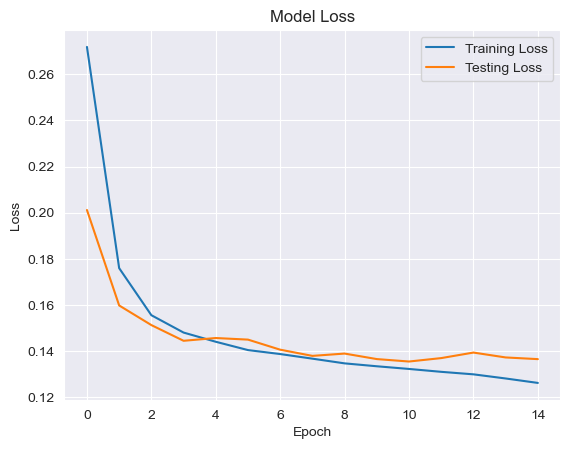

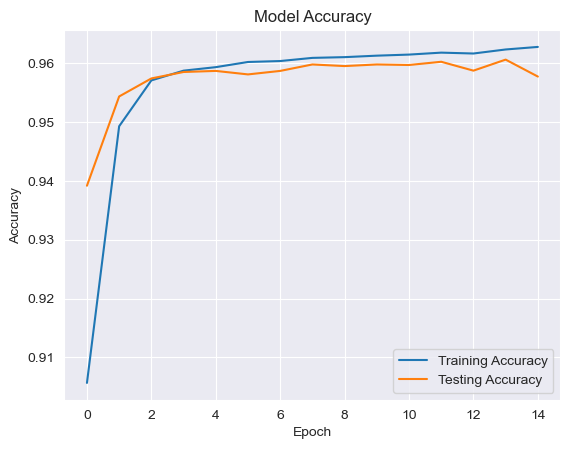

In [53]:
# Plot the training and testing loss
plt.title('Model Loss')
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and testing accuracy
plt.title('Model Accuracy')
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [54]:
# Print the last testing accuracy
print(f'Final Testing Accuracy: {test_accs[-1]:.4f}')


Final Testing Accuracy: 0.9578


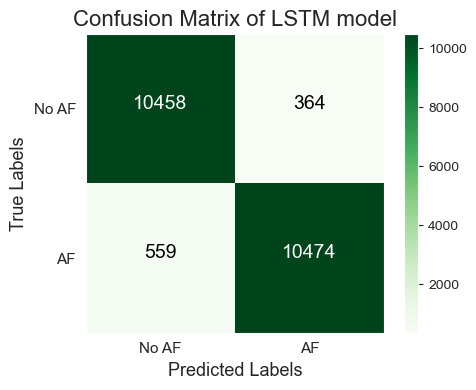

              precision    recall  f1-score   support

       No AF       0.95      0.97      0.96     10822
          AF       0.97      0.95      0.96     11033

    accuracy                           0.96     21855
   macro avg       0.96      0.96      0.96     21855
weighted avg       0.96      0.96      0.96     21855

Test accuracy: 0.958 | Test F1-score: 0.958


In [72]:
#print confusion matrix:

model.eval()  
with torch.no_grad():  
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float() 
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

class_labels = ['No AF', 'AF']
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(confusion, cmap=plt.cm.Greens)
plt.title('Confusion Matrix of LSTM model', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=13)
plt.ylabel('True Labels', fontsize=13)
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, fontsize=11)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels, fontsize=11)
plt.grid(False)

# Annotate the squares
threshold = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > threshold else "black", fontsize=14)

plt.colorbar()
plt.tight_layout()
plt.savefig('images/confusion_matrix_LSTM.png')
plt.show()

# Print the precision, recall, F1-score
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Calculate and print accuracy and F1 score
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_accuracy = accuracy_score(y_true, y_pred)
print(f'Test accuracy: {test_accuracy:.3f} | Test F1-score: {test_f1:.3f}')

Create a Decision Tree classifier on our own version of the preprocessed data, to verify the results of the given preprocessed data

In [14]:
X = x_bins.iloc[:, :-1].values
y = x_bins.iloc[:, -1].values

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

(109272, 31) (109272,)


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_dt}, F1: {f1_dt}")

Accuracy: 0.9341111873713109, F1: 0.9334073251942286


Plot some samples

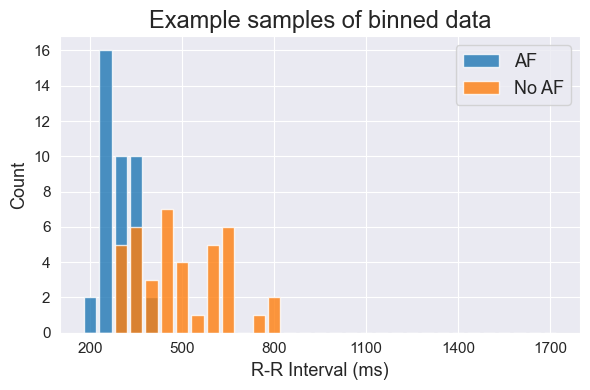

In [20]:
class_1_bins = x_bins[x_bins['Class_Label'] == 1]
class_0_bins = x_bins[x_bins['Class_Label'] == 0]

s_n1 = 1 # sample number to plot
s_n0 = 1
# class_sn = class_1_bins.iloc[s_n1, -1]
plt.figure(figsize=(6, 4))
plt.bar(range(len(class_1_bins.columns) - 1), class_1_bins.iloc[s_n1, :-1], label='AF', alpha=0.8)
plt.bar(range(len(class_0_bins.columns) - 1), class_0_bins.iloc[s_n0, :-1], alpha=0.8, label='No AF')

step_size = len(bin_edges) // 5
selected_indices = np.arange(0, len(bin_edges)-1, step_size)
selected_labels = [bin_edges[i] for i in selected_indices]

plt.xticks(selected_indices, selected_labels, rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('R-R Interval (ms)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title(f'Example samples of binned data', fontsize=17)
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('images/binned_samples.png')
plt.show()

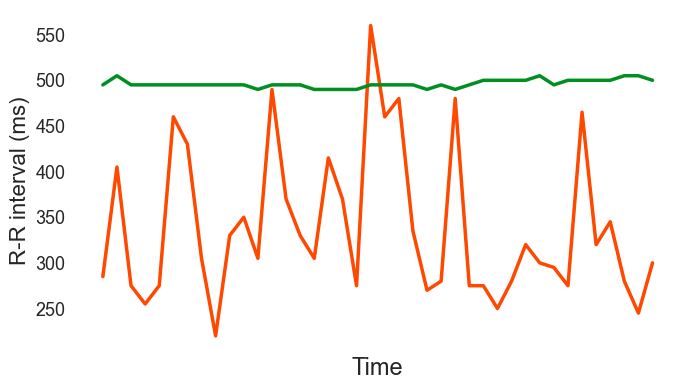

In [44]:
# class_1 holds the samples with AF
# class_0 holds the samples without AF
# Plot a sample from each class in the same plot

s_n0 = 2
s_n1 = 2

plt.figure(figsize=(7, 4))
plt.plot(class_1.iloc[s_n1, :-1], label='AF', alpha=1, linewidth=2.5, color=(255/255, 72/255, 0/255))
plt.plot(class_0.iloc[s_n0, :-1], label='No AF', alpha=1, linewidth=2.5, color=(0/255, 143/255, 33/255))

plt.xlabel('Time', fontsize=17)
plt.ylabel('R-R interval (ms)', fontsize=16)
#plt.title('Two Samples', fontsize=18)
#place legend right outside of the plot, also swap the labels
#plt.legend(fontsize=13, loc='center left', bbox_to_anchor=(1, 0.5))
tick_positions = range(0, len(class_1.columns) - 1, 5)  # Assuming both class_1 and class_0 have the same number of columns
tick_labels = range(1, 41, 5)
# plt.xticks(tick_positions, tick_labels, fontsize=11)
#disable xticks
plt.xticks([])
plt.yticks(fontsize=13)
plt.grid(False)
#remove background color
plt.gca().patch.set_facecolor('white')

plt.tight_layout()
plt.savefig('images/raw_samples_presentation.png')
plt.show()

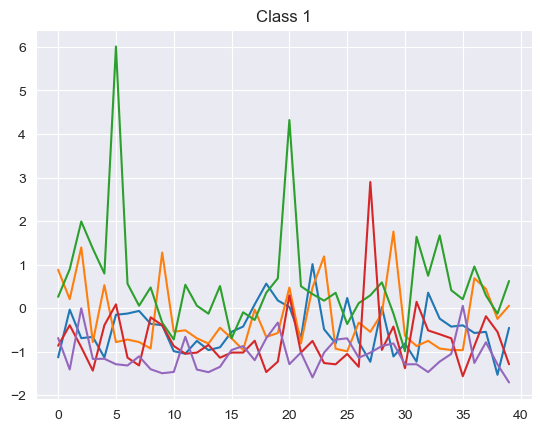

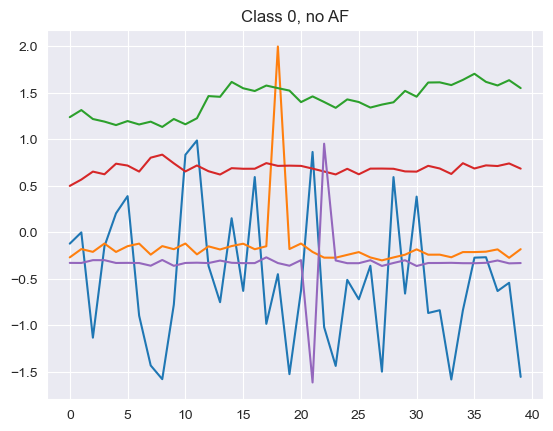

In [21]:
#plot 5 samples with class 1 and 5 samples with class 0 from the training loader
class_1_bins = []
class_0_bins = []
for inputs, labels in train_loader:
    for i in range(len(labels)):
        if labels[i] == 1:
            class_1_bins.append(inputs[i])
        else:
            class_0_bins.append(inputs[i])
    if len(class_1_bins) >= 5 and len(class_0_bins) >= 5:
        break

for i in range(5):
    plt.title('Class 1')
    plt.plot(class_1_bins[i].squeeze())
plt.show()

for i in range(5):
    plt.title('Class 0, no AF')
    plt.plot(class_0_bins[i].squeeze())
plt.show()